# Predicate-based classifiers
Predicate C04: Neoplasms <br>
Predicate C12: Urologic and Male Genital Diseases <br>
Predicate C10: Nervous System Diseases <br>
Predicate C14: Cardiovascular Diseases <br>
Predicate C23: Pathological Conditions, Signs and Symptoms

In [18]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

In [19]:
df1 = pd.read_csv('./data/ohsumed_C10_C23_1grams.csv')
df2 = pd.read_csv('./data/ohsumed_C14_C23_1grams.csv')
df3 = pd.read_csv('./data/ohsumed_C04_C12_1grams.csv')

In [20]:
seed = 123
k = 10

def get_data(predicate, df):
    X_pos = df.loc[df[predicate] == 1]['tokens'].values
    pos_num = len(X_pos)
#     X_neg = df.loc[df[predicate] == 0]['tokens'].values[:pos_num] # balanced data
    X_neg = df.loc[df[predicate] == 0]['tokens'].values # imbalanced data
    neg_num = len(X_neg)
    X = np.append(X_pos, X_neg)
    y = np.append(np.ones(pos_num), np.zeros(neg_num))    
    return X, y


pipeline  = Pipeline([
    ('vect', CountVectorizer(lowercase=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(class_weight='balanced', random_state=seed))
])

param_grid = {
    'vect__max_features': [2000],
    'vect__ngram_range': [(1, 1)],
    'clf__C': [0.01, 0.1, 1]
}

predicate_list = ['C10', 'C14', 'C23', 'C04', 'C12']
score_list = []
std_list = []

for predicate, df in zip(predicate_list, [df1, df2, df2, df3, df3]):
    X_train, y_train = get_data(predicate, df)
    grid = GridSearchCV(pipeline, cv=k, param_grid=param_grid, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    score_mean = grid.cv_results_['mean_test_score'][grid.best_index_]
    score_list.append(score_mean)
    score_std = grid.cv_results_['std_test_score'][grid.best_index_]
    std_list.append(score_std)

    print('{} best: {:1.3f} std: {:1.3f}, using {}'.format(predicate, score_mean, score_std, grid.best_params_))

C10 best: 0.539 std: 0.057, using {'clf__C': 0.01, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}
C14 best: 0.782 std: 0.080, using {'clf__C': 0.1, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}
C23 best: 0.523 std: 0.030, using {'clf__C': 0.1, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}
C04 best: 0.777 std: 0.049, using {'clf__C': 0.01, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}
C12 best: 0.629 std: 0.085, using {'clf__C': 0.01, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}


### Plot F1 score for predicate-based classifiers

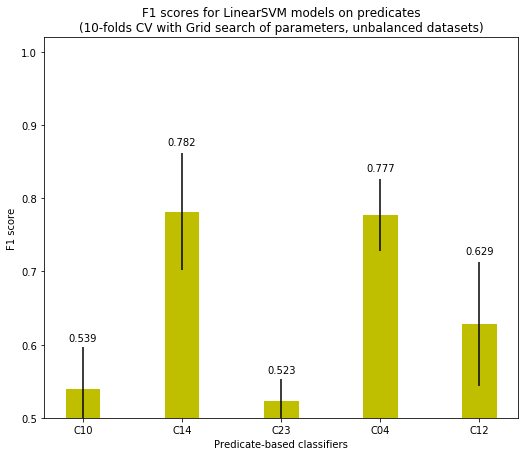

In [22]:
%matplotlib inline  
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8.5,7))
width = 0.35 
rects = ax.bar(predicate_list, score_list, width, color='y', yerr=std_list)
ax.set_ylim((0.5, 1.02))
ax.set_ylabel('F1 score')
ax.set_xlabel('Predicate-based classifiers')
ax.set_title('F1 scores for LinearSVM models on predicates\n(10-folds CV with Grid search of parameters, unbalanced datasets)')

def autolabel(rects, values, errors):
    """
    Attach a text label above each bar displaying its height
    """
    for rect, val, e in zip(rects, values, errors):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*(height+e),
                '{:1.3f}'.format(val),
                ha='center', va='bottom')

autolabel(rects, score_list, std_list)